<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic13/Ensemble_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

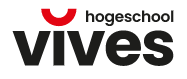<br>


**DEEP LEARNING**<br>
Academiejaar 2023-2024<br>
Andy Louwyck

---



---



# **How to Develop an Ensemble of Deep Learning Models in Keras**

Section 13.1.2 from the book "Deep Learning with Python (2nd Ed.)" by François Chollet (2021) states that:

*You should ensemble models that are as good as possible while being
as different as possible. This typically means using very different architectures or even
different brands of machine learning approaches. One thing that is largely not worth
doing is ensembling the same network trained several times independently, from different
random initializations. If the only difference between your models is their random
initialization and the order in which they were exposed to the training data, then
your ensemble will be low-diversity and will provide only a tiny improvement over any
single model.*

However, according to the following *Machine Learning Mastery* blog by Jason Brownlee, an ensemble of a model trained several times from different random initializations may reduce the model variance:

https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/


What does Jason Brownlee mean by the model variance? Well, let's dive into the classification example he discusses in the blog!

## Import statements

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

## The dataset

Generate 2D classification dataset containing 500 samples, 2 features, and 3 classes:

In [23]:
# generate 2d classification dataset
X, y_int = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
print(X.shape)
print(y_int.shape)

(500, 2)
(500,)


Scatter plot of the dataset:

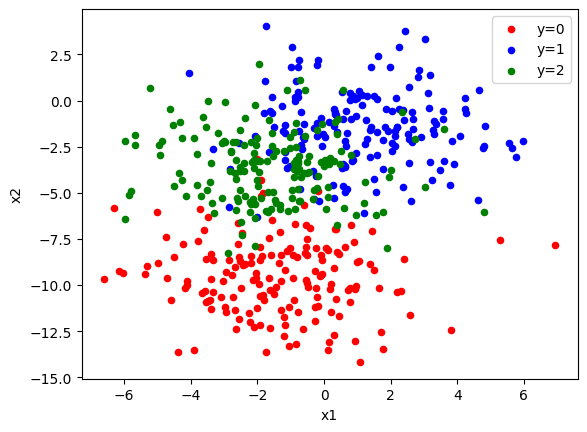

In [3]:
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y_int))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label='y='+str(key), color=colors[key])

## Model for Multi-Class Classification

Apply one-hot encoding to the labels:

In [4]:
y = to_categorical(y_int)
print(y.shape)
print(y[0])

(500, 3)
[0. 1. 0.]


Split the dataset:

In [24]:
# split into train and test
n_train = int(0.3 * X.shape[0])
trainX, valX = X[:n_train, :], X[n_train:, :]
trainy_int, valy_int = y_int[:n_train], y_int[n_train:]
trainy, valy = y[:n_train], y[n_train:]

Create a simple multilayer fead-forward network:

In [6]:
# define model
model = Sequential()
model.add(Dense(15, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model:

In [7]:
# fit model
history = model.fit(trainX, trainy,
                    validation_data=(valX, valy),
                    epochs=200,
                    verbose=0)  # no output

Evaluate the model:

In [8]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, val_acc = model.evaluate(valX, valy, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

Train: 0.853, Validation: 0.757


Plot evolution of accuracy:

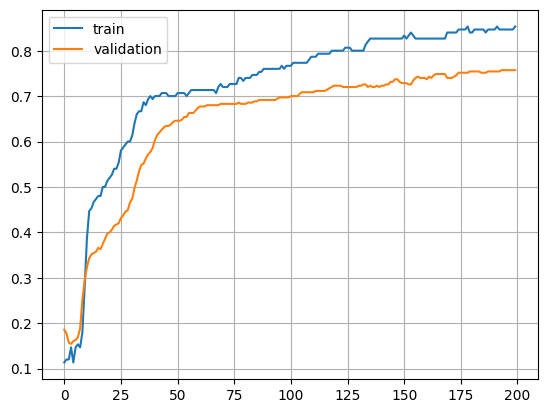

In [9]:
# learning curves of model accuracy
plt.plot(history.history['accuracy'], label='train');
plt.plot(history.history['val_accuracy'], label='validation');
plt.legend();
plt.grid();

We can see that the model is not really overfit, but is perhaps a little underfit and may benefit from an increase in capacity, more training, and perhaps some regularization. All of these improvements of which we intentionally hold back to force the high variance for our case study.

## High Variance of the Model

We copy-paste the code from previous section and define functions:

In [10]:
# fit model on dataset
def fit_model(trainX, trainy):
    # define model
    model = Sequential()
    model.add(Dense(15, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(trainX, trainy, epochs=200, verbose=0)
    return model

In [11]:
# fit and evaluate a neural net model on the dataset
def evaluate_model(trainX, trainy, valX, valy):
    # fit model
    model = fit_model(trainX, trainy)
    # evaluate the model
    _, val_acc = model.evaluate(valX, valy, verbose=0)
    return val_acc

Now let's train the model 30 times and evaluate each model on the validation set:

In [12]:
# repeated evaluation
n_repeats = 30
scores = list()
for _ in range(n_repeats):
    score = evaluate_model(trainX, trainy, valX, valy)
    print('> %.3f' % score)
    scores.append(score)

> 0.766
> 0.771
> 0.783
> 0.777
> 0.774
> 0.780
> 0.743
> 0.771
> 0.780
> 0.769
> 0.786
> 0.760
> 0.740
> 0.771
> 0.769
> 0.746
> 0.763
> 0.749
> 0.766
> 0.743
> 0.731
> 0.740
> 0.780
> 0.757
> 0.737
> 0.734
> 0.769
> 0.749
> 0.746
> 0.769


Calculate the mean accuracy and the standard deviation:

In [13]:
# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (np.mean(scores), np.std(scores)))

Scores Mean: 0.761, Standard Deviation: 0.016


In this case, we can see that the average of the sample is 76.1 % with a standard deviation of 1.6 %. Assuming a Gaussian distribution, we would expect 99 % of accuracy scores to fall between 3 standard deviations above and below the mean:

In [14]:
print(76.3 + 1.8 * 3 * np.array([-1, 1]))

[70.9 81.7]


Plot a histogram and a boxplot of the scores:

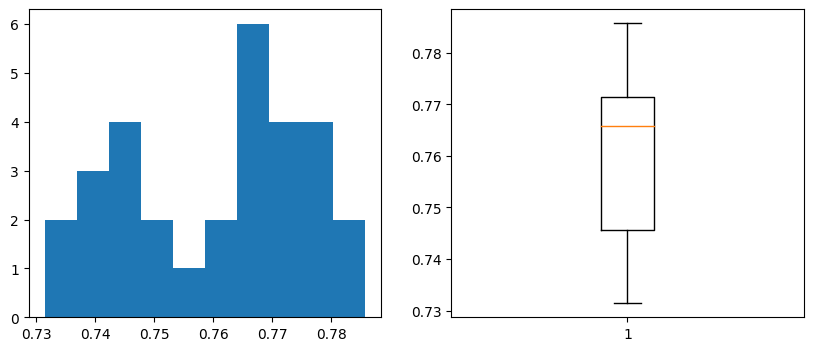

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4));
ax1.hist(scores, bins=10);
ax2.boxplot(scores);

The boxplot show a median of about 76.5 % and an interquartile range between approximately 73.5% and 78.5%.

The analysis of the sample of validation scores clearly demonstrates a variance in the performance of the same model trained on the same dataset.

## Model Averaging Ensemble

We can use model averaging to both reduce the variance of the model and possibly reduce the generalization error of the model. Specifically, this would result in a smaller standard deviation on the validation set and a better performance on the training set. We can check both of these assumptions.

Define a function that makes an ensemble prediction for the classification problem:

In [16]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(models, valX):
    # make predictions
    yhats = np.array([model.predict(valX, verbose=0) for model in models])
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)  # sum or mean work both as the argmax is taken to get the predicted class
    # argmax across classes
    result = np.argmax(summed, axis=1)
    return result

Define a function that evaluate the first `n_models` in the ensemble:

In [20]:
# evaluate a specific number of members in an ensemble
def evaluate_n_models(models, n_models, valX, valy):
    # select a subset of members
    subset = models[:n_models]
    print(len(subset))
    # make prediction
    yhat = ensemble_predictions(subset, valX)
    # calculate accuracy
    return accuracy_score(valy, yhat)

Train an ensemble of 20 models:

In [18]:
n_models = 20
models = [fit_model(trainX, trainy) for _ in range(n_models)]

Evaluate the different number of ensembles, ranging from 1 model to 20 models:

In [25]:
# evaluate different numbers of ensembles
scores = list()
for i in range(1, n_models+1):
    score = evaluate_n_models(models, i, valX, valy_int)
    print('> %.3f' % score)
    scores.append(score)

1
> 0.789
2
> 0.789
3
> 0.780
4
> 0.771
5
> 0.774
6
> 0.771
7
> 0.771
8
> 0.771
9
> 0.771
10
> 0.771
11
> 0.771
12
> 0.771
13
> 0.771
14
> 0.771
15
> 0.771
16
> 0.771
17
> 0.771
18
> 0.771
19
> 0.771
20
> 0.771


Plot the accuracy of the ensembles versus the number of models in the ensemble:

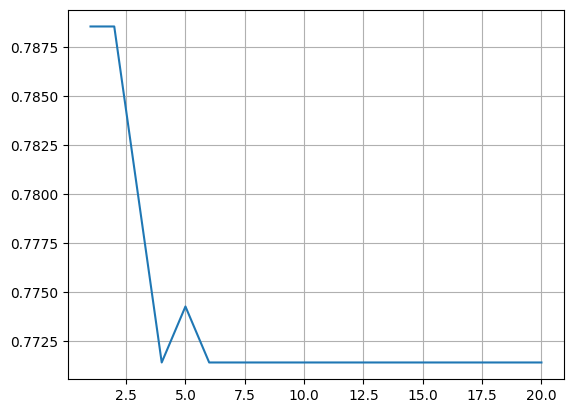

In [26]:
# plot score vs number of ensemble members
plt.plot([i for i in range(1, n_models+1)], scores);
plt.grid();

We can see that performance improves to about six members, after which performance plateaus around 77.1% accuracy. This is close to the average validation set performance observed during the analysis of the repeated evaluation of the model in previous section.

## Low Variance of the Ensemble Model

Now we train 30 ensembles of 6 models and evaluate each ensemble on the validation set. To do so, we first need to define a function to evaluate an ensemble:

In [29]:
# evaluate ensemble model
def evaluate_ensemble(models, valX, valy):
    # make prediction
    yhat = ensemble_predictions(models, valX)
    # calculate accuracy
    return accuracy_score(valy, yhat)

Train and evaluate the ensembles:

In [32]:
# repeated evaluation
n_repeats = 30
n_models = 6
scores = list()
for _ in range(n_repeats):
	# fit all models
	models = [fit_model(trainX, trainy) for _ in range(n_models)]
	# evaluate ensemble
	score = evaluate_ensemble(models, valX, valy_int)
	print('> %.3f' % score)
	scores.append(score)

> 0.771
> 0.763
> 0.757
> 0.766
> 0.754
> 0.771
> 0.771
> 0.766
> 0.760
> 0.771
> 0.769
> 0.769
> 0.763
> 0.769
> 0.769
> 0.783
> 0.771
> 0.774
> 0.769
> 0.771
> 0.763
> 0.766
> 0.769
> 0.777
> 0.763
> 0.766
> 0.774
> 0.774
> 0.763
> 0.774


Calculate the mean accuracy and the standard deviation:

In [33]:
# summarize the distribution of scores
print('Scores Mean: %.3f, Standard Deviation: %.3f' % (np.mean(scores), np.std(scores)))

Scores Mean: 0.768, Standard Deviation: 0.006


In this case, we can see that the average is 76.8 %, which is very close to the average of the 30 single models, but here, the standard deviation is only 0.6 %! Assuming a Gaussian distribution, we would expect 99 % of accuracy scores to fall between 3 standard deviations above and below the mean:

In [34]:
print(76.8 + 0.6 * 3 * np.array([-1, 1]))

[75.  78.6]


Plot a histogram and a boxplot of the scores:

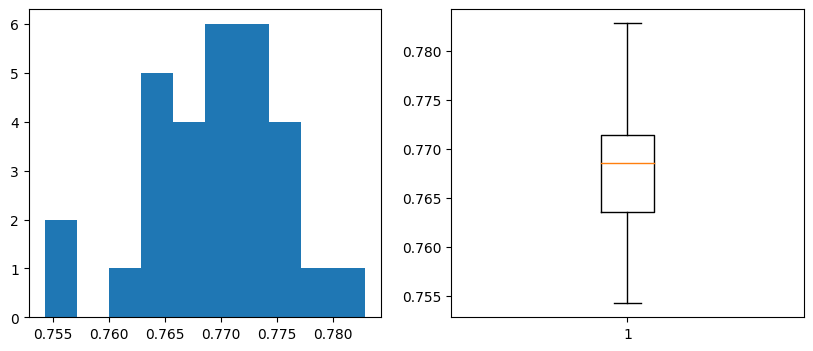

In [35]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4));
ax1.hist(scores, bins=10);
ax2.boxplot(scores);

The boxplot show a median of about 76.8 % and an interquartile range between approximately 75.5% and 78.5%.

**The important difference is the standard deviation shrinking from 1.6% for a single model to 0.6% with an ensemble of six models!!**

This demonstrates that for this specific model and prediction problem, that a model averaging ensemble with six members is sufficient to reduce the variance of the model. This reduction in variance, in turn, also means a better on-average performance when preparing a final model.

However, as argued by François Chollet (2021), we need to combine different machine learning models to enhance the performance in general:

*One thing I have found to work well in practice — but that doesn’t generalize to every problem domain — is using an ensemble of tree-based methods (such as random forests or gradient-boosted trees) and deep neural networks. In 2014, Andrey Kolev and I took fourth place in the Higgs Boson decay detection challenge on Kaggle using an ensemble of various tree models and deep neural networks. Remarkably, one of the models in the ensemble originated from a different method than the others (it was a regularized greedy forest), and it had a significantly
worse score than the others. Unsurprisingly, it was assigned a small weight in the ensemble. But to our surprise, it turned out to improve the overall ensemble by a large factor, because it was so different from every other model: it provided information that the other models didn’t have access to. That’s precisely the point of ensembling. It’s not so much about how good your best model is; it’s about the diversity of
your set of candidate models.*

---